In [1]:
import os
os.environ["ROS_MASTER_URI"]="http://fetch48.local:11311"
# os.environ["OPENAI_API_KEY"] = ""

In [2]:
%load_ext autoreload
%matplotlib inline
from IPython.display import display

In [3]:
# python -m pip install 'git+https://github.com/MaureenZOU/detectron2-xyz.git'

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt

import sys
sys.path.append(".")
sys.path.append("../../")
import os

from utils.logging import CustomLogger
from utils import logging
from agents import agent_factory

from executor import SimpleExecutor, LineWiseExecutor

from utils.image_utils import visualize_image, resize_image


/home/anxing/anaconda3/envs/masks/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
logger = CustomLogger()
logging.set_logger(logger)

In [5]:
from environments.real_world import RealWorldEnv
env = RealWorldEnv()
env.setup()

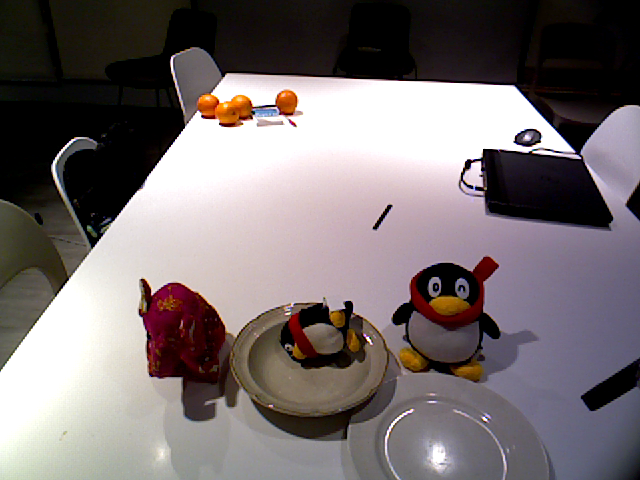

In [11]:
env.get_image()

In [7]:
def run_experiment(env, agent, prompt, debug=True):
    print("Image before planning: ")
    image = env.get_image()
    visualize_image(image)
    plan_result = agent.try_plan(prompt, image)
    print(plan_result)
    
    if not plan_result.success:
        return
        
    print("Annotated image: ")
    visualize_image(plan_result.annotated_image)
    # Build a context containing the masks for the plan code to access
    masks_context = {"regions": plan_result.masks}

    # Fake execution for inspection
    global inspect_logger
    context, inspect_logger = env.get_inspect_execution_context(plan_image=image)
    inspect_executor = SimpleExecutor(context)
    inspect_executor.execute_plan(plan_result.plan_code, additional_context=masks_context)
    print("-" * 50)
    print("A visualization of the plan to execute:")
    display(inspect_logger.display_html_logs_in_notebook())
    print("-" * 50)

    if input("Continue to execute in the real world?") not in ['y']:
        print("Execution terminated by user.")
        return

    # Real execution
    executor = LineWiseExecutor(env.get_execution_context(agent=agent, logger=logger), pause_every_line=True)
    executor.execute_plan(plan_result.plan_code, additional_context=masks_context)

    print("After manipulation: ")
    visualize_image(env.get_image())

    return plan_result

Specify Your task here.

In [8]:
prompt="""Task: Put the smallest toy into the taller plate."""
# prompt="""Task: Put all oranges without a label into the bowl."""

Image before planning: 


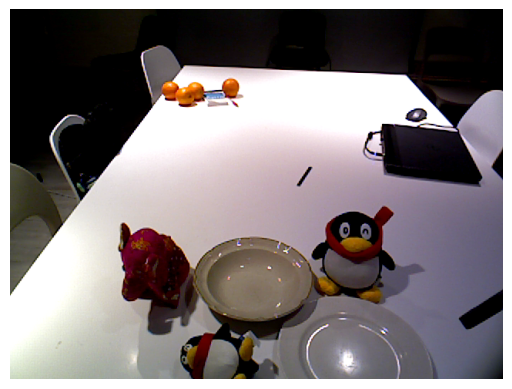

PlanResult(success=True,
 exception=None,
plan_raw="To complete the task, I need to identify the smallest toy and the taller plate from the objects highlighted in the image. The toys in the image are marked with numbers 3, 4, and 5, and the plates are marked with numbers 1 and 2. \n\nFrom the image, it appears that object 4 is the smallest toy, and object 2 is the taller plate. Therefore, the robot should pick up the smallest toy (object 4) and place it into the taller plate (object 2).\n\nHere is the plan in Python code:\n\n```python\npick(obj=regions[4])\nplace(obj=regions[2], orientation='inside')\n```\n\nPlease note that the offset is not provided because the task does not specify a particular position within the plate, and the default behavior should suffice to place the toy inside the plate without collisions.",
 masks=<2 masks>,
 prompt='Task: Put the smallest toy into the taller plate.',
 plan_code="\npick(obj=regions[1])\nplace(obj=regions[0], orientation='inside')\n",
 annota

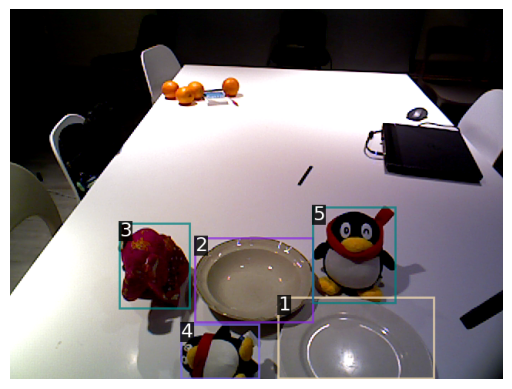

--------------------------------------------------
A visualization of the plan to execute:



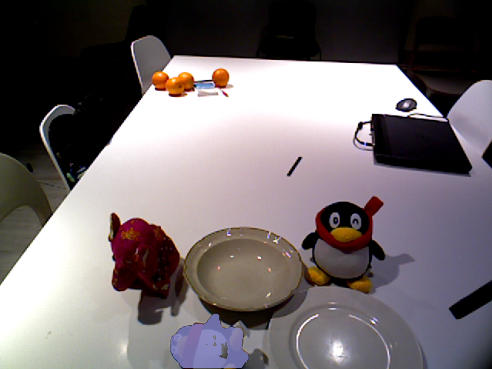
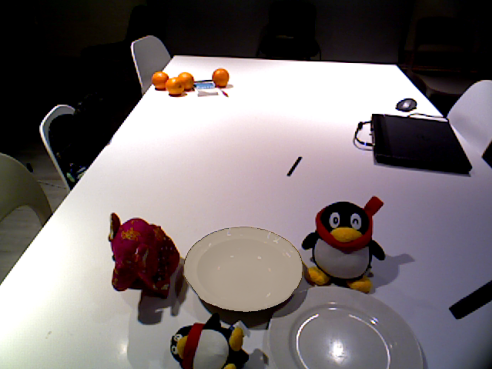

--------------------------------------------------
Executing plan code:
1: pick(obj=regions[1])
2: place(obj=regions[0], orientation='inside')
____________________________________________________________________________________________________
(Executor) Executing line 1: pick(obj=regions[1])
(Executor) Executing line 2: place(obj=regions[0], orientation='inside')
reidentify: toy
matches: []


Error on line 2: Failed to reidentify the object.


RuntimeError: Failed to reidentify the object.

In [9]:
agent = agent_factory("DOM")
# agent.configs["img_size"] = 640
plan_result = run_experiment(env, agent, prompt)


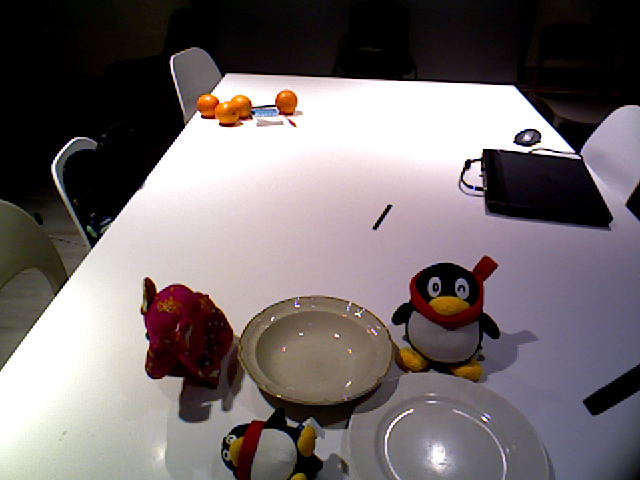
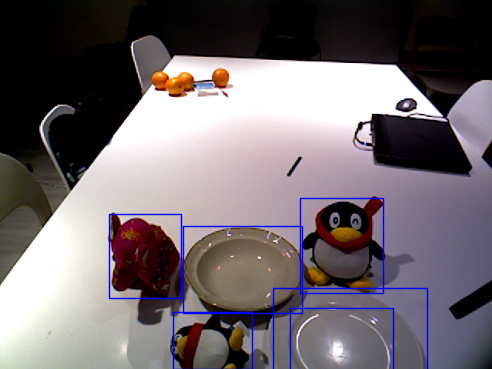
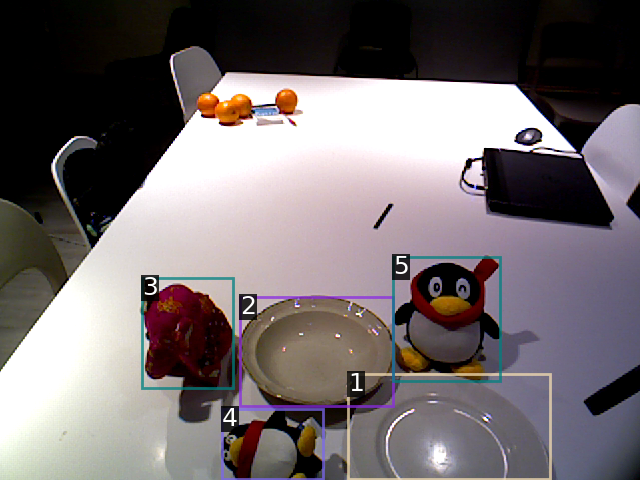
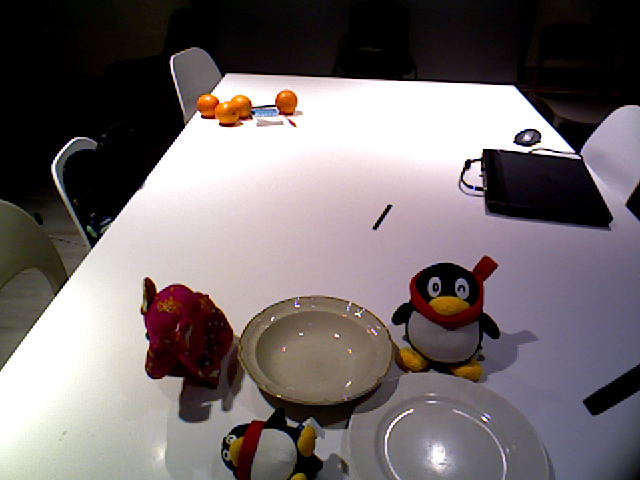
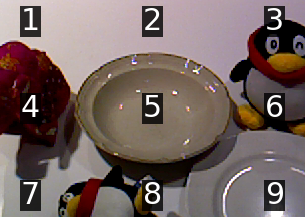
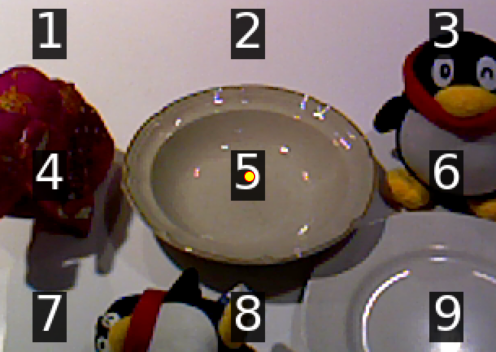
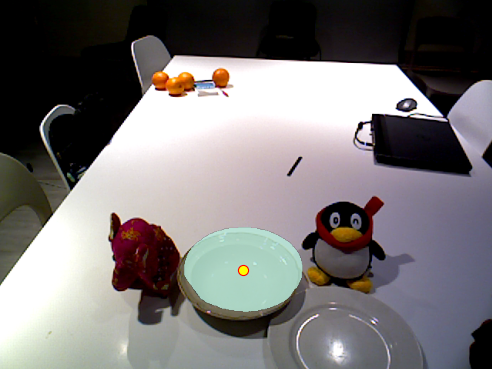

In [10]:
logging.get_logger().display_html_logs_in_notebook()

In [11]:
logger.save_logs_to_html_file("result.html")